# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [172]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [173]:
# Calculate the number of interactions each user has with articles
user_interactions = df.groupby('email')['article_id'].count().reset_index()
user_interactions.columns = ['email', 'interaction_count']

user_interactions.head()

,email,interaction_count
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


In [174]:
# Descriptive statistics
interaction_stats = user_interactions['interaction_count'].describe()
print(interaction_stats)

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: interaction_count, dtype: float64


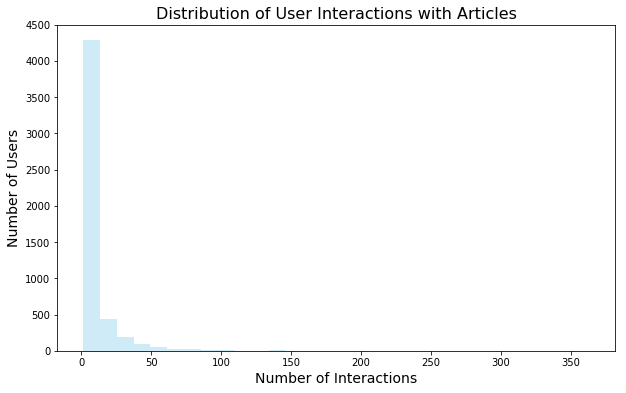

In [175]:
# Plot the histogram with pretty colors
plt.figure(figsize=(10, 6))
sns.distplot(user_interactions['interaction_count'], bins=30, kde=False, color='skyblue')

# Customize the plot with labels and title
plt.title('Distribution of User Interactions with Articles', fontsize=16)
plt.xlabel('Number of Interactions', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Show the plot
plt.show()

In [176]:
user_interactions.head()

,email,interaction_count
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


In [177]:
# Calculate the median number of interactions per user
median_val = df.groupby('email')['article_id'].count().median()

# Find the maximum number of interactions by any single user
max_views_by_user = df.groupby('email')['article_id'].count().max()

median_val, max_views_by_user

(3.0, 364)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [178]:
def eliminate_duplicate_articles(data_frame):
    """
    Eliminate duplicate articles from the DataFrame.

    This function removes duplicate entries from the DataFrame based on the 'article_id' column,
    retaining only the first instance of each article.

    Args:
    - data_frame: DataFrame containing article information.

    Returns:
    - cleaned_data_frame: DataFrame with duplicates removed.
    - num_duplicates_before: Number of duplicate articles prior to removal.
    - num_duplicates_after: Number of duplicate articles after removal.
    """
    # Determine the number of duplicate articles before removal
    num_duplicates_before = data_frame.duplicated(subset='article_id').sum()

    # Remove duplicate articles
    cleaned_data_frame = data_frame.drop_duplicates(subset='article_id', keep='first')

    # Determine the number of duplicate articles after removal
    num_duplicates_after = cleaned_data_frame.duplicated(subset='article_id').sum()

    return cleaned_data_frame, num_duplicates_before, num_duplicates_after

# Eliminate duplicate articles
cleaned_df_content, num_duplicates_before, num_duplicates_after = eliminate_duplicate_articles(df_content)

# Display the results
print("\nNumber of duplicate articles before removal:", num_duplicates_before)
print("Number of duplicate articles after removal:", num_duplicates_after)
print("DataFrame shape after removing duplicates:", cleaned_df_content.shape)



Number of duplicate articles before removal: 5
Number of duplicate articles after removal: 0
DataFrame shape after removing duplicates: (1051, 5)


### Remove any rows that have the same article_id - only keep the first

In [179]:
print(type(df_content))
print(df_content)

<class 'pandas.core.frame.DataFrame'>
                                               doc_body  \
0     Skip navigation Sign in SearchLoading...\r\n\r...   
1     No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2     ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3     DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4     Skip navigation Sign in SearchLoading...\r\n\r...   
5     Compose is all about immediacy. You want a new...   
6     UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...   
7     Follow Sign in / Sign up 135 8 * Share\r\n * 1...   
8     * Host\r\n * Competitions\r\n * Datasets\r\n *...   
9     THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...   
10    OFFLINE-FIRST IOS APPS WITH SWIFT & PART 1: TH...   
11    Warehousing data from Cloudant to dashDB great...   
12    Skip to main content IBM developerWorks / Deve...   
13    Maureen McElaney Blocked Unblock Follow Follow...   
14    Raj Singh Blocked Unblock Follow Following Dev...   
15    * Home\r\n *

In [180]:
# If df_content is a tuple, extract the DataFrame
if isinstance(df_content, tuple):
    df_content = df_content[0]

# If df_content is a list of DataFrames, iterate through them
if isinstance(df_content, list):
    for i, df in enumerate(df_content):
        print(f"DataFrame {i}:")
        print(df.head())

# Check if df_content is now a DataFrame
if isinstance(df_content, pd.DataFrame):
    # Find duplicate rows based on 'article_id'
    duplicate_rows = df_content[df_content.duplicated(subset='article_id', keep=False)]

    # Display the duplicate rows
    print("Duplicate rows based on 'article_id':")
    print(duplicate_rows)
else:
    print("df_content is not a DataFrame.")

Duplicate rows based on 'article_id':
                                              doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
232  Homepage Follow Sign in Get started Homepage *...   
365  Follow Sign in / Sign up Home About Insight Da...   
399  Homepage Follow Sign in Get started * Home\r\n...   
578  This video shows you how to construct queries ...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
50                        Community Detection at Scale   
221  When used to make sense of huge amounts of con...   
232  If you are like most data scientists, you are ...   
365  During the seven-week Insight Data Engineering...   
399  Today’s world of data scienc

In [181]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [182]:
# a. Calculate the number of unique articles that users have interacted with
unique_interacted_articles = df['article_id'].nunique()

# b. Determine the total number of unique articles in the dataset (including those without interactions)
total_unique_articles = cleaned_df_content['article_id'].drop_duplicates().count()

# c. Find the number of unique users in the dataset (ignoring null values)
total_unique_users = df['email'].nunique()

# d. Count the total number of user-article interactions in the dataset
total_interactions = len(df)

print("a. Number of unique articles with interactions:", unique_interacted_articles)
print("b. Total number of unique articles in the dataset:", total_unique_articles)
print("c. Number of unique users in the dataset:", total_unique_users)
print("d. Total number of user-article interactions in the dataset:", total_interactions)

a. Number of unique articles with interactions: 714
b. Total number of unique articles in the dataset: 1051
c. Number of unique users in the dataset: 5148
d. Total number of user-article interactions in the dataset: 45993


In [183]:
user_article_interactions=len(df) #The total number of user-article interactions in the dataset
unique_articles=df['article_id'].nunique() #The number of unique articles that have an interaction with a user.
unique_users=df['email'].nunique() #The number of unique users in the dataset
total_articles=cleaned_df_content['article_id'].drop_duplicates().count() #The number of unique articles on the IBM platform

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [184]:
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?

print("Most viewed article_id:", most_viewed_article_id)
print("maximum views",max_views)

Most viewed article_id: 1429.0
maximum views 937


In [185]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [186]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [187]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('title').size().sort_values(ascending=False).head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id').size().sort_values(ascending=False).head(n).index.tolist()
 
    return top_articles # Return the top article ids

In [188]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [189]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [190]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id']).size().unstack()
    
    # Fill NaN values with 0
    user_item = user_item.fillna(0)
    
    # Convert values to binary (1 for interactions, 0 otherwise)
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [191]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [192]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity
    similarity = user_item.dot(user_item.loc[user_id])

    # sort 
    similarity = similarity.sort_values(ascending=False)

    # create id list
    most_similar_users = similarity.index.tolist()
   
    # remove user_id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [193]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [194]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str')
    
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recommended_articles = np.array([])  # Initialize list of recommendations

    # Articles already seen by the input user
    user_articles_seen = get_user_articles(user_id)[0]
    
    # Find similar users based on interactions with articles
    similar_users = find_similar_users(user_id)

    for similar_user_id in similar_users:
        # Articles seen by the similar user
        similar_user_articles_seen = get_user_articles(similar_user_id)[0]
        
        # Find articles not seen by the input user
        new_recommendations = np.setdiff1d(similar_user_articles_seen, user_articles_seen, assume_unique=True)
        
        # Concatenate arrays and keep only unique values
        recommended_articles = np.unique(np.concatenate([new_recommendations, recommended_articles], axis=0))

        # Exit loop if the number of recommendations exceeds the specified limit
        if len(recommended_articles) > m - 1:
            break

    # Limit recommendations to the specified number
    recs = recommended_articles[:m].tolist()
    
    return recs # return your recommendations for this user_id  

In [195]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [196]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [197]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # Create an empty dataframe to store neighbor information
    sorted_neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity'])
    sorted_neighbors_df['neighbor_id'] = user_item.index - 1
    # Compute similarity using dot product of user_item_matrix
    similarity_scores = user_item.dot(np.transpose(user_item))
    sorted_neighbors_df['similarity'] = similarity_scores[user_id]
    # Create a dataframe to count the number of interactions per user
    interactions_df = df.user_id.value_counts().rename_axis('neighbor_id').reset_index(name='num_interactions')
    # Merge the neighbor dataframe with the interactions dataframe
    sorted_neighbors_df = pd.merge(sorted_neighbors_df, interactions_df, on='neighbor_id', how='outer')
    # Sort the dataframe by similarity and then by number of interactions
    sorted_neighbors_df = sorted_neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    # Reset the index
    sorted_neighbors_df = sorted_neighbors_df.reset_index(drop=True)
    # Exclude the user for whom neighbors are found
    neighbors_df = sorted_neighbors_df[sorted_neighbors_df.neighbor_id != user_id]
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recommendations = np.array([])  # Initialize list of recommendations

    # Articles already seen by the input user
    user_articles_seen_ids, _ = get_user_articles(user_id, user_item)
    
    # Find similar users based on interactions with articles
    closest_neighbors = get_top_sorted_users(user_id, df=df, user_item=user_item).neighbor_id.tolist()

    for neighbor_id in closest_neighbors:
        # Articles seen by the neighbor user
        neighbor_articles_seen_ids, _ = get_user_articles(user_id, user_item)
        
        # Find articles not seen by the input user
        new_recommendations = np.setdiff1d(neighbor_articles_seen_ids, user_articles_seen_ids, assume_unique=True)
        
        # Concatenate arrays and keep only unique values
        recommendations = np.unique(np.concatenate([new_recommendations, recommendations], axis=0))

        # Exit loop if the number of recommendations exceeds the specified limit
        if len(recommendations) > m - 1:
            break

    # Limit recommendations to the specified number
    recommendations = recommendations[:m]
    recs = recommendations.tolist()
    rec_names = get_article_names(recommendations, df=df)
    
    return recs, rec_names

In [198]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[]

The top 10 recommendations for user 20 are the following article names:
[]


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [199]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [200]:
get_top_sorted_users(131)

,neighbor_id,similarity,num_interactions
1,3870,74.0,144.0
2,3782,39.0,363.0
3,23,38.0,364.0
4,203,33.0,160.0
5,4459,33.0,158.0
6,98,29.0,170.0
7,3764,29.0,169.0
8,49,29.0,147.0
9,3697,29.0,145.0
10,242,25.0,148.0


In [201]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

"I'll opt for user_user_recs_part2. It’s a great initial step to recommend articles from the most active users, ensuring these articles are also highly interacted with. For new users, we can inquire about their preferences and then suggest top articles that align with those preferences. As we gather more data on them, we can transition to matrix factorization."

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [202]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
top_articles = df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index[:10].tolist()

new_user_recs = [str(article_id) for article_id in top_articles] # Your recommendations here

In [203]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [204]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [205]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [206]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [207]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [208]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item, full_matrices=False)

In [209]:
num_nulls = user_item.isnull().sum().sum()
print("Number of null values in the user-item matrix:", num_nulls)

Number of null values in the user-item matrix: 0


In [210]:
# Display the shapes of the resulting matrices
print("Shape of U:", u.shape)
print("Shape of S:", s.shape)
print("Shape of VT:", vt.shape)

Shape of U: (5149, 714)
Shape of S: (714,)
Shape of VT: (714, 714)


Since this matrix has no missing values, we can use SVD. In the classroom, our matrix had missing values, so we had to use FunkSVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

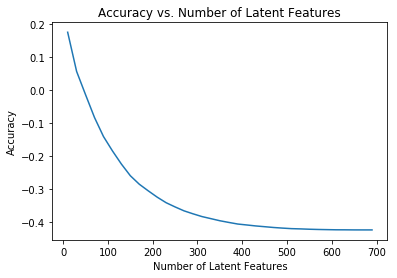

In [211]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [212]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item matrix for the training data
    user_item_train = create_user_item_matrix(df_train)
    
    # Create user-item matrix for the test data
    user_item_test = create_user_item_matrix(df_test)
    
    # Get all user ids in the test set
    test_idx = user_item_test.index.values
    
    # Get all article ids in the test set
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [213]:
"""
Replace the values in the dictionary below with appropriate values.

- a: Number of users we can't make predictions for because of the cold start problem.
- b: Number of articles we can make predictions for in the test set.
- c: Number of users we can make predictions for in the test set.
- d: Number of articles we can't make predictions for because of the cold start problem.

Returns:
    sol_4_dict (dict): A dictionary containing the answers to the questions.
"""

# Assign values to variables
a = 662  # Number of users we can't make predictions for because of the cold start problem
b = 574  # Number of articles we can make predictions for in the test set
c = 20   # Number of users we can make predictions for in the test set
d = 0    # Number of articles we can't make predictions for because of the cold start problem


# Replace the values in the dictionary below
sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

# This should be article not movies. it was bugging me and wasted some time on it
t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [214]:
# Apply SVD to the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)  # Perform SVD as demonstrated earlier, then proceed with the following cells


In [215]:
# shape of the dataset
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [216]:
"""
Performs matrix factorization and evaluates the recommendation system's performance with different numbers of latent features.

Args:
    user_item_train (pd.DataFrame): User-item matrix of the training set.
    user_item_test (pd.DataFrame): User-item matrix of the test set.
    u_train (np.array): U matrix from the matrix factorization of the training set.
    s_train (np.array): Singular values array from the matrix factorization of the training set.
    vt_train (np.array): V transpose matrix from the matrix factorization of the training set.
    test_idx (list): List of user IDs in the test set.
    test_arts (list): List of article IDs in the test set.

Returns:
    sum_errs_train (list): List of total errors for the training set with different numbers of latent features.
    sum_errs_test (list): List of total errors for the test set with different numbers of latent features.
"""

import numpy as np

# Initialize lists to store total errors for training and testing sets
sum_errs_train = []
sum_errs_test = []

# Generate an array of latent feature numbers from 10 to 700 in steps of 20
num_latent_feats = np.arange(10, 700 + 10, 20)

# Extract the rows and columns for the test set
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

# Subset the matrices for the test set
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

# Find users in the test set that exist in both training and test sets
users_can_predict = np.intersect1d(list(user_item_train.index), list(user_item_test.index))

# Iterate over different numbers of latent features
for k in num_latent_feats:
    # Decompose matrices with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]
    
    # Predict interactions for training and test sets
    user_item_train_preds = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_k, s_train_k), vt_test_k))
    
    # Calculate prediction errors by comparing to actual values
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[users_can_predict, :], user_item_test_preds)
    
    # Compute total errors and store them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)


In [217]:
num_latent_feats

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510,
       530, 550, 570, 590, 610, 630, 650, 670, 690])

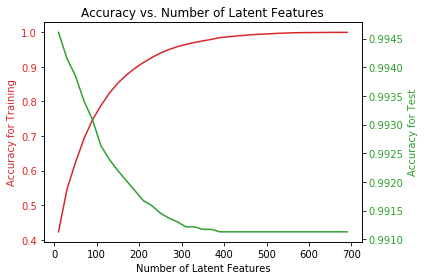

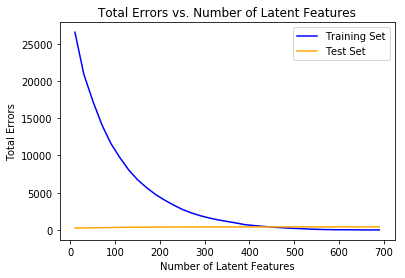

In [218]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_latent_features(num_latent_feats, sum_errs_train, sum_errs_test):
    """
    Generates plots showing the accuracy and total errors against the number of latent features.

    Args:
        num_latent_feats (array-like): Array of numbers representing the latent features.
        sum_errs_train (array-like): Array of total errors for the training set with different numbers of latent features.
        sum_errs_test (array-like): Array of total errors for the test set with different numbers of latent features.
    
    Returns:
        None
    """
    
    # Plotting accuracy for training and test sets
    fig, ax1 = plt.subplots()

    # Plotting accuracy for the training set
    color = 'tab:red'
    ax1.set_xlabel('Number of Latent Features')
    ax1.set_ylabel('Accuracy for Training', color=color)
    ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train) / df.shape[0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title('Accuracy vs. Number of Latent Features')

    # Creating a secondary y-axis for accuracy of the test set
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Accuracy for Test', color=color)  # we already handled the x-label with ax1
    ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test) / df.shape[0], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Adjusting layout
    fig.tight_layout()

    # Displaying the plot
    plt.show()

    # Additional visualization: Plotting total errors for training and test sets
    fig2, ax = plt.subplots()
    ax.plot(num_latent_feats, sum_errs_train, label='Training Set', color='blue')
    ax.plot(num_latent_feats, sum_errs_test, label='Test Set', color='orange')
    ax.set_xlabel('Number of Latent Features')
    ax.set_ylabel('Total Errors')
    ax.set_title('Total Errors vs. Number of Latent Features')
    ax.legend()
    plt.show()

# Example usage
plot_accuracy_vs_latent_features(num_latent_feats, sum_errs_train, sum_errs_test)


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The recommendation system's accuracy improves on the training set but declines on the test set as more latent features are added, indicating potential overfitting. To assess system efficacy, an A/B test could split users into treatment and control groups, evaluating metrics like user engagement and satisfaction. If the treatment group shows substantial improvement over the control, it would suggest the new recommendation system's effectiveness compared to the existing approach.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [219]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0